### Notebook Description

This notebook contains the autoencoder and is for visualsing the training progress and outputs for a single aperture. The notebook can be used to check that the network behaves as expected and can read the preprocessed data. If you wish to train on all apertures and extract a master telluric spectrum use 'training.py' script.

Steps included in this notebook:
 1. Load preprocessed data
 2. Choose aperture to train on and obtain suggested hyperparameters and set up dataloader
 3. Set up network and use custom initialisation of decoder weights
 4. Train network
 5. Inspect results
 6. Save results. 

### Loading  Data

In [1]:
# Importing packages and functions
from scipy import interpolate
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import torch
import torch.nn as nn
from scipy import interpolate
from torch.utils.data import DataLoader
from functions import shift
from functions import doppler_shift
from functions import logconv
from functions import nonLogconv
from functions import EarlyStopping
from hyperparameters import hyperparams
from dataloader import dataloader

print('Loading Data...')

# Loading preprocessed data
pkl_file = open('../preproc/preproc_wave.pkl', 'rb')
preproc_wave = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('../preproc/preproc_flux.pkl', 'rb')
preproc_flux = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('../preproc/preproc_airmass.pkl', 'rb')
Airmass = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('../preproc/preproc_berv.pkl', 'rb')
Berv = pickle.load(pkl_file)
pkl_file.close()

# Collecting dimension parameters
n_apertures = preproc_flux.shape[1] # Number of apertures in training data
P = preproc_flux.shape[2] # Spectral bands in each aperture

# Loading molecfit sample for custom initialisation of decoder weights
df_data = pd.read_csv('../molecfit/telluric_sample_separate.txt', delimiter = ' ', skiprows = 0,header=0)
mol_O2 = df_data['tel_O2_1']
wave_mol_O2 = df_data['wl_O2_1']
mol_H2O = df_data['tel_H2O_1']
wave_mol_H2O = df_data['wl_H2O_1']

# Converting molecfit wave to Ångstrøm
wave_mol_H2O = wave_mol_H2O* 10
wave_mol_O2 = wave_mol_O2* 10

print('Finished Loading Data')

Loading Data...
Finished Loading Data


### Choosing an aperture to train on

In [3]:
# Some interesting apertures / orders for HARPS data are 53 and 54 for H2O and 60 for O2
order = 53
validation = True # Decide whether to use a validation set

# Gathering suggested hyperparameters for the aperture
epochs,learning_rate,n_dim= hyperparams(order)
earlyStopping = EarlyStopping(patience=50)

# Optionally change number of epochs
epochs=epochs*2

# Setting up dataloader. 
batch_size,train,val,dataloader_train,dataloader_val,wave,berv_ref_init_s = dataloader(order,preproc_wave,preproc_flux,Berv,validation)

# Learning rate adjustment with batch size
learning_rate = learning_rate / (838/batch_size)

print('Aperture:',order)
print('Epochs',epochs)
print('Latent Dimensions:',n_dim)
print('Using Validation:',validation)

Aperture: 53
Epochs 800
Latent Dimensions: 2
Using Validation: True


# Autoencoder Model

In [4]:
# =================================== Initializing decoder weights ============================
# Using custom initialisation of decoder H2O and O2 weights from Molecfit sample.
# This ensures faster convergence.

# Log conversion of molecfit
mol_o2 = logconv(mol_O2)
mol_h2o = logconv(mol_H2O)

# Interpolate to AE wave grid
f = interpolate.interp1d(wave_mol_H2O, mol_h2o)
mol_h2o = f(wave)

f = interpolate.interp1d(wave_mol_O2, mol_o2)
mol_o2 = f(wave)

# Upscaling init Molecfit for faster convergence  
mol_h2o = mol_h2o*5-4  
mol_o2=mol_o2 *1.33-0.33  

# Defining init O2 and H2O endmember
O2 = mol_o2 -1
H2O = mol_h2o -1

# Defining init S endmember as observation from training set with least telluric contamination. 
s = train[np.argmax(np.mean(train, axis=1))]

# Removing Oxygen lines from init S for faster training  
Airmass_frac = Airmass[np.argmax(np.mean(train, axis=1))] / np.max(Airmass)
s = s-O2*Airmass_frac*1

# Choosing Init scheme based on number of latent dimensions.
init = ([s,H2O])
if n_dim==3:
    init = ([s,H2O,O2])

# Making init array readable by network.
init = np.asarray(init).T
init = np.float32(init)

# Dropout
p = 0

# ============================== Defining layers and model architecture  ======================

num_features = len(train[0]) # Input and output layer dimension is number of bands to training data 
class AutoEncoder(nn.Module):
    def __init__(self, latent_features):  
        super(AutoEncoder, self).__init__()
    
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=latent_features,bias=True), 
            nn.Dropout(p),
            nn.LeakyReLU(),   
            nn.BatchNorm1d(latent_features,affine=False,track_running_stats=True,momentum=0),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features,out_features=num_features,bias=False) # Not using bias terms for direct interpretation
        )
 # --------------------------------------- Initializing -------------------------------------

        # Using custom initialization scheme for decoder weights
        self.decoder[0].weight.data = torch.from_numpy(init)
        
        # Alternativley use standard xavier init scheme
       # torch.nn.init.xavier_normal_(self.decoder[0].weight, gain=nn.init.calculate_gain('leaky_relu'))

        # Using xavier/glorot for encoder with optimal gain for faster learning
        torch.nn.init.xavier_normal_(self.encoder[0].weight, gain=nn.init.calculate_gain('leaky_relu'))
        

 # ======================================= Forward Pass =====================================

 # ----------------------------------------- Encoder ----------------------------------------
    def forward(self, x,ref_berv): 
        z = self.encoder(x) # defining z's as the different abundances from the latent space. 
        #--- ---------------- Controlling endmember abundance range -------------------
        # z are the endmember abundance weights
        # Solar endmember abundance is constrained as a constant 1
        z[:,0] = 1
        
        # H2O Endmember transforming to range [0,1]
        z[:,1] = z[:,1]-np.min(z[:,1].detach().numpy())        # Casting to positive values 
        z[:,1] = z[:,1] / np.max(z[:,1].detach().numpy())      # Normalizing to max value of 1
          
        # H2O Endmember transforming to range [c2,1]
        z[:,1] = z[:,1] +0.035                                 # Lower bound c2 = 1-1/(1+x). x=0.035 gives range [0.03,1]
        z[:,1] = z[:,1] / np.max(z[:,1].detach().numpy())      # Normalizing to max value of 1
        
        if n_dim==3:
            # O2 Endmember transforming to range [0,1]
            z[:,2] = z[:,2]-np.min(z[:,2].detach().numpy())    # Casting to positive values   
            z[:,2] = z[:,2] / np.max(z[:,2].detach().numpy())  # Normalizing to max value of 1

            # O2 Endmember transforming to range [c3,1]
            z[:,2] = z[:,2] + 2.2                              # Lower bound c3 = 1-1/(1+x). x=2.2 gives range [0.69,1]
            z[:,2] = z[:,2] / np.max(z[:,2].detach().numpy())  # Normalizing to max value of 1
             
        # ------- Controlling endmember spectra range -------
        
        # Deciding S_top slack for clamp range. 
        S_top = 1.005
        if order==60:
            S_top=1.001

        # Solar
        w0 = self.decoder[0].weight[:,0].clamp(0,S_top)        # Clamping at [0,1] to interpret as continuum normalised spectrum 
        self.decoder[0].weight.data[:,0]=w0                    # Allowing clamp slightly over 1.00 to S_top in case of poor continuum normalisation
        
        # H2O
        w1 = self.decoder[0].weight[:,1].clamp(-1,0)           # Clamping at [-1,0] to interpret as absorption
        self.decoder[0].weight.data[:,1]=w1                    
        
        # O2
        if n_dim==3:
            w2 = self.decoder[0].weight[:,2].clamp(-1,0)       # Clamping at [-1,0] to interpret as absorption
            self.decoder[0].weight.data[:,2]=w2

 # --------------------------------------- Decoder ------------------------------------------

        # Reconstruction x_hat has to be constructed manually to use custom doppler shift function
        # Constructing X_hat from sum of products between latent weights (z's) and decoder weights
        # X_hat = S * w1 + H2O * w2 + O2 * W3    
        # Solar endmember is doppler shifted for each observed spectrum
        
        # H2O and O2 endmembers are identical between batch members
        # S endmember is individually doppler shifted (using defined function) towards each observed spectrum
        
        # Optionally use non-shifted solar endmembers by replacing S definition with the following line: 
        #S = self.decoder[0].weight[:,0].unsqueeze(0).repeat(batch_size, 1)   
        # This will speed up computation time a lot, but will include noise in endmembers from doppler shift of S

        # Expanding endmember weights to batch dimension
        S   = doppler_shift(self.decoder[0].weight[:,0].unsqueeze(0).repeat(batch_size, 1),batch_size,wave,ref_berv)

        H2O = self.decoder[0].weight[:,1].unsqueeze(0).repeat(batch_size, 1)
        
        # If n_dim = 3 include O2
        if n_dim==3: 
            O2  = self.decoder[0].weight[:,2].unsqueeze(0).repeat(batch_size, 1)
               
        # Adding a singleton dimension to z's to perform element-wise product correctly.
        z1 =  z[:,0][:,None]
        z2 =  z[:,1][:,None]
        
        if n_dim ==3:
            z3 =  z[:,2][:,None]      
        
        # Constructing x_hat
        x_hat = S*z1 + H2O*z2   
        
        # if n_dim = 3 include O2
        if n_dim==3:
            x_hat = S*z1 + H2O*z2  + O2*z3
        
        # Collecting endmembers as decoder weights
        # Collected Solar endmember is non-shifted from initialized S. 
        decoder_weights = self.decoder[0].weight
        
        return x_hat,z,decoder_weights
        
# Creating network and setting shape of latent space
net = AutoEncoder(latent_features=n_dim)
print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=2, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(2, eps=1e-05, momentum=0, affine=False, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=False)
  )
)



### Training

Training...
Estimated Training Time:  87.0 s

Epoch 25/800: (2.0s) train loss 5.827176323691674e-07
Epoch 50/800: (4.0s) train loss 4.81033680443943e-07
Epoch 75/800: (5.0s) train loss 4.4066422333344235e-07
Epoch 100/800: (7.0s) train loss 4.136656173159281e-07
Epoch 125/800: (9.0s) train loss 3.909716213001957e-07
Epoch 150/800: (10.0s) train loss 3.715142042892694e-07
Epoch 175/800: (12.0s) train loss 3.5450841551210033e-07
Epoch 200/800: (14.0s) train loss 3.3995198123193404e-07
Epoch 225/800: (16.0s) train loss 3.2689916906747385e-07
Epoch 250/800: (17.0s) train loss 3.157555568122916e-07
Epoch 275/800: (19.0s) train loss 3.060914650632185e-07
Epoch 300/800: (21.0s) train loss 2.974326775984082e-07
Epoch 325/800: (23.0s) train loss 2.898667901263252e-07
Epoch 350/800: (24.0s) train loss 2.829336551712913e-07
Epoch 375/800: (26.0s) train loss 2.76897708317847e-07
Epoch 400/800: (28.0s) train loss 2.712223476919462e-07
Epoch 425/800: (30.0s) train loss 2.6603657943269354e-07
Epoch 4

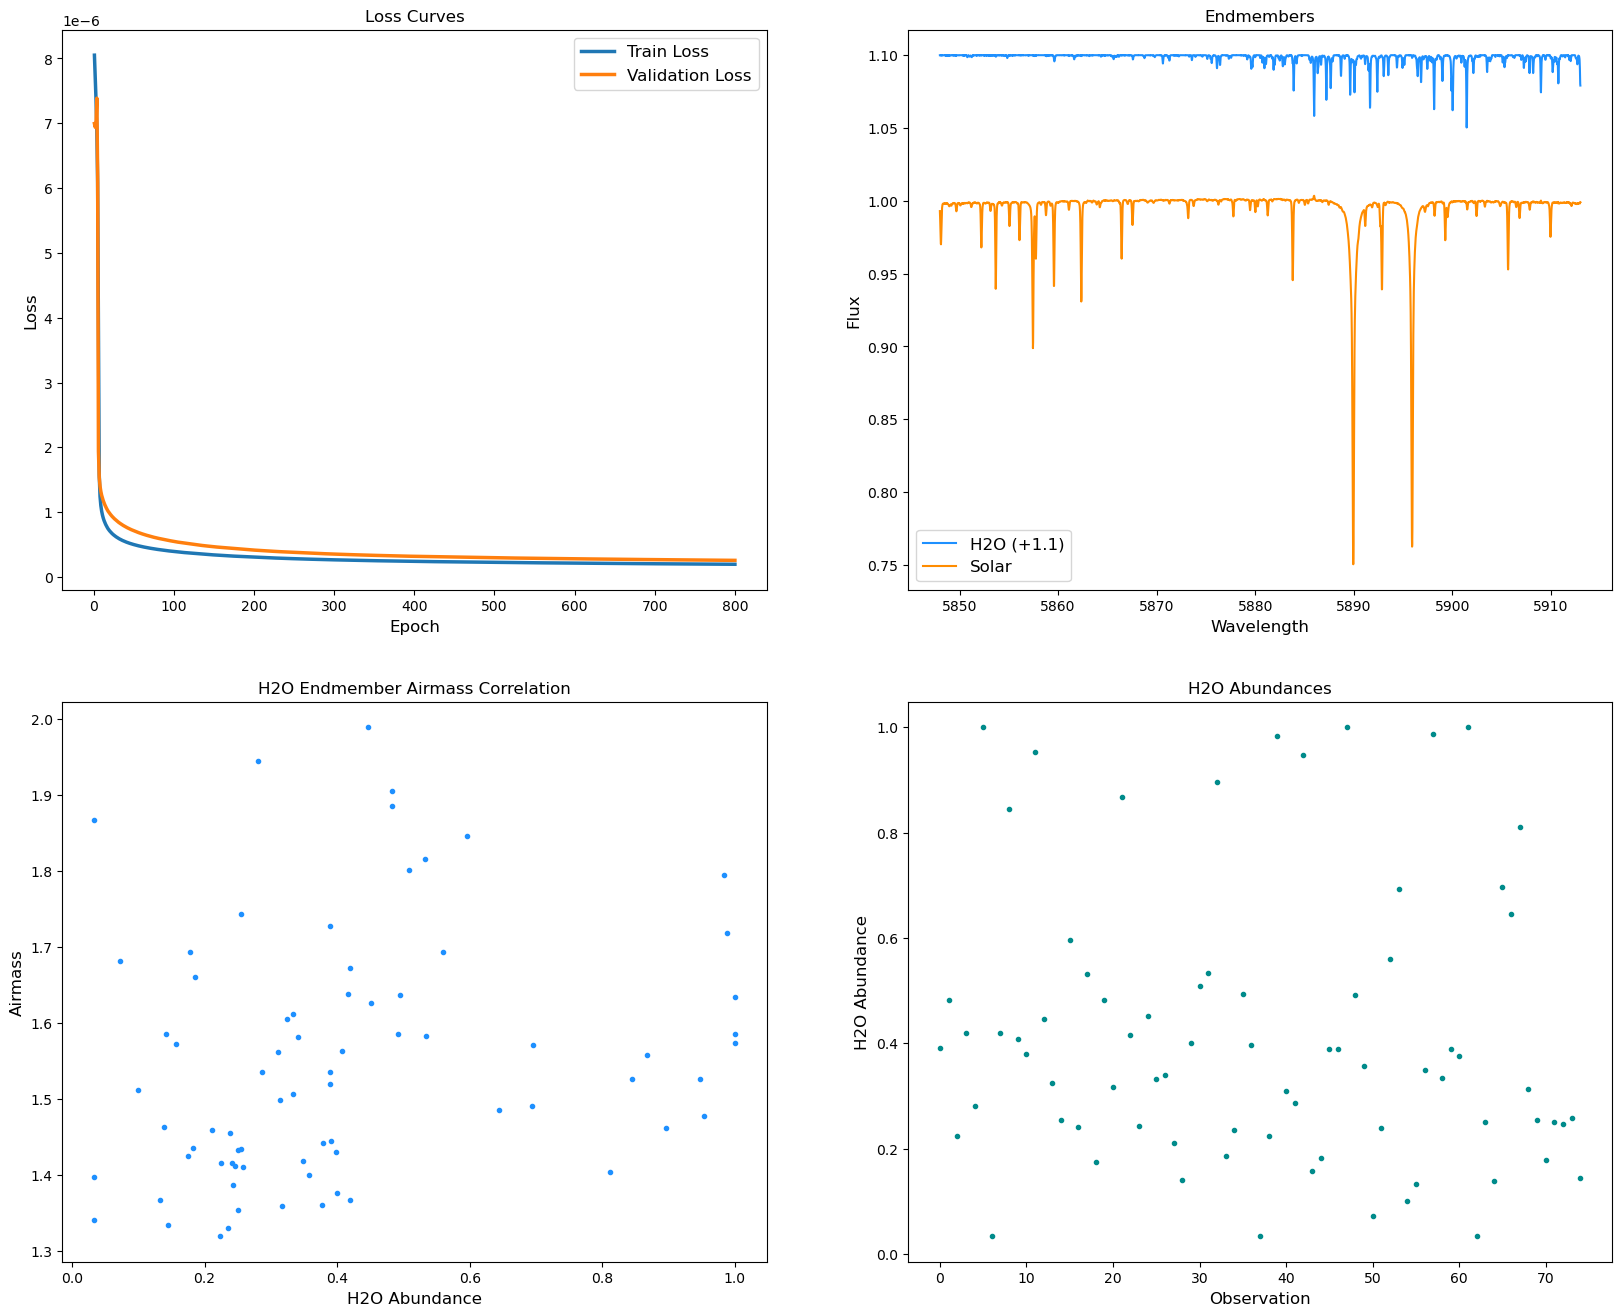

In [5]:
num_epochs = epochs # number of epochs
print_counter = 25 # interval to print training progress 

# Initializing lists to save progress in
t_loss=[]
v_loss=[]
z1_saved = []
z2_saved = []

# Loss function
criterion = nn.MSELoss()

# Training parameters
lr=learning_rate 
momentum = 0
weight_decay  = 0
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
        
# =================================== TRAINING ===========================================
counter = 0 # starting counter and time to track training
start = time.time()
print("Training...")


for epoch in range(1,num_epochs+1):
    net=net.train()   # Set mode to train
    loss_train = []
    for count,data in enumerate(dataloader_train):
    
        # Define input data
        x = data
        
        # Define berv relative to init s berv
        start_id = batch_size*count     # start id of obs in batch
        stop_id  = batch_size*(count+1) # end id of obs in batch
        ref_berv = berv_ref_init_s[start_id:stop_id]

    # ===================forward=====================
        # clear out the gradients of variables 
        optimizer.zero_grad()    
        
        # Collect reconstruction x_hat from network
        x_hat,z,weights = net(x,ref_berv)
        
        # Define loss between reconstruction x_hat and input x
        train_loss = criterion(x_hat, x)
        
        loss_train.append(train_loss.item())

        # Saving H2O endmember abundances for plotting
        z1_saved.append(z[:,1].detach().numpy())
        
        # Save O2 abundance if n_dim = 3
        if n_dim==3:
            z2_saved.append(z[:,2].detach().numpy())
        
    # =================== backward ====================   
        train_loss.backward()
        optimizer.step()
        
    # =================== validation ==================
    
    if validation==True:
        #val_loss = []
        loss_val = []
        with torch.no_grad():
            for data in dataloader_val:
                net.eval()    # Set mode to evalutation

                x_val = data 
                
                # Setting BERVS for doppler shift of solar component
                count+=1                        # Keeping track of batches
                start_id = batch_size*count     # start id of obs in batch
                stop_id  = batch_size*(count+1) # end id of obs in batch
                if stop_id > berv_ref_init_s.shape[0]: # doppler shift function needs batches to be full
                    break                              # if bervs cannot fill a batch skip val of this batch 
                else:
                    ref_berv = berv_ref_init_s[start_id:stop_id]
                
                x_hat_val,_,_  = net(x_val,ref_berv)
                val_loss = criterion(x_hat_val, x_val)
                loss_val.append(val_loss.item())
                           
    # ======================== log  ===================
    t_loss.append(np.mean(loss_train))

    if validation==True:
        v_loss.append(np.mean(loss_val))
        
    
    # val_loss:    Val Loss for current batch
    # loss_val:    List of val loss pr batch for current epoch
    # v_loss:      List of val loss pr epoch (list of mean loss_val for each epoch)
    
    # train_loss:  Train Loss for current batch
    # loss_train:  List of train loss pr batch for current epoch
    # t_loss:      List of train loss pr epoch (list of mean loss_train for each epoch)
    
    # ======================== Early Stopping  =================== 
    if validation==True:
        if earlyStopping.step(torch.tensor(v_loss[epoch-1]),net): # val loss step at each epoch
            print('Exited due to early stopping at epoch',epoch)
            net = earlyStopping.bestModel # Best model is here the model where the training was stopped. 
            break  # early stop criterion is met, we can stop now
            
    
    # Printing estimated training time and update total training time used so far
    if epoch == 1:
        print(f'Estimated Training Time:  {round((time.time()-start)*num_epochs,0)} s\n')
    counter += 1
    if (counter == print_counter):
        counter=0
        print(f'Epoch {epoch}/{num_epochs}: ({round(time.time()-start,0)}s) train loss {train_loss}')
print('\nTotal Time Elapsed for Training:',round(time.time()-start,0),'s')

# Save weights as endmembers and save the correct spectral region
endmember = weights.detach().numpy()
Wave = wave
if order in {56,59,60,61,62,65,66,67,68}:
    endmember = endmember[P:]
    Wave = wave[P:]
        
if order==58:
    endmember = endmember[P:P*2]
    Wave = wave[P:P*2]
        
if order<=54:
    endmember = endmember[:P]
    Wave = wave[:P]

# Collecting epochs and endmember abundances for plotting       
epoch = np.arange(num_epochs)+1
z1_saved=np.asarray(z1_saved)
z1=z1_saved[int(len(z1_saved)-(len(train)/batch_size)):].flatten()
if n_dim==3:
    z2_saved=np.asarray(z2_saved)
    z2=z2_saved[int(len(z2_saved)-(len(train)/batch_size)):].flatten()

# Plotting Diagnostics
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(20,16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

fontsize=12
plt.subplot(2, 2, 1).title.set_text('Loss Curves')
ax1.set_xlabel('Epoch',fontsize=fontsize)
ax1.set_ylabel('Loss',fontsize=fontsize)
plt.plot(epoch[0:len(t_loss)], t_loss, label='Train Loss',linewidth=2.5)
if validation==True:
    plt.plot(epoch[0:len(v_loss)], v_loss, label='Validation Loss',linewidth=2.5)
ax1.legend(fontsize=fontsize)

if n_dim==2:
    plt.subplot(2, 2, 2).title.set_text('Endmembers')
    ax2.set_xlabel('Wavelength',fontsize=fontsize)
    ax2.set_ylabel('Flux',fontsize=fontsize)
    plt.plot(Wave,endmember[:,1]+1.1,label='H2O (+1.1)',color='dodgerblue')
    plt.plot(Wave,endmember[:,0],label='Solar',color='darkorange')
    ax2.legend(fontsize=fontsize)

if n_dim==3:
    plt.subplot(2, 2, 2).title.set_text('Input and Reconstruction')
    ax2.set_xlabel('Wavelength',fontsize=fontsize)
    ax2.set_ylabel('Flux',fontsize=fontsize)
    plt.plot(Wave,endmember[:,2]+1.2,label='O2 (+1.2)',color='green')
    plt.plot(Wave,endmember[:,1]+1.1,label='H2O (+1.1)',color='dodgerblue')
    plt.plot(Wave,endmember[:,0],label='Solar',color='darkorange')
    ax2.legend(fontsize=fontsize)
     
plt.subplot(2, 2, 3).title.set_text('H2O Endmember Airmass Correlation')
ax3.set_ylabel('Airmass',fontsize=fontsize)
ax3.set_xlabel('H2O Abundance',fontsize=fontsize)
plt.plot(z1,Airmass[0:len(train)],'.',color='dodgerblue')

if n_dim==2:
    plt.subplot(2, 2, 4).title.set_text('H2O Abundances')
    ax4.set_xlabel('Observation',fontsize=fontsize)
    ax4.set_ylabel('H2O Abundance',fontsize=fontsize)
    plt.plot(z1,'.',color='darkcyan')

if n_dim==3:
    plt.subplot(2, 2, 4).title.set_text('O2 Endmember Airmass Correlation')
    ax4.set_xlabel('O2 Abundance',fontsize=fontsize)
    ax4.set_ylabel('Airmass',fontsize=fontsize)
    plt.plot(z2,Airmass[0:len(train)],'.',color='mediumseagreen')
plt.show()

### Inspecting results
If trained on aperture 53 then inspect plot below to check known H2O tellurics around 5900 Å are found correctly

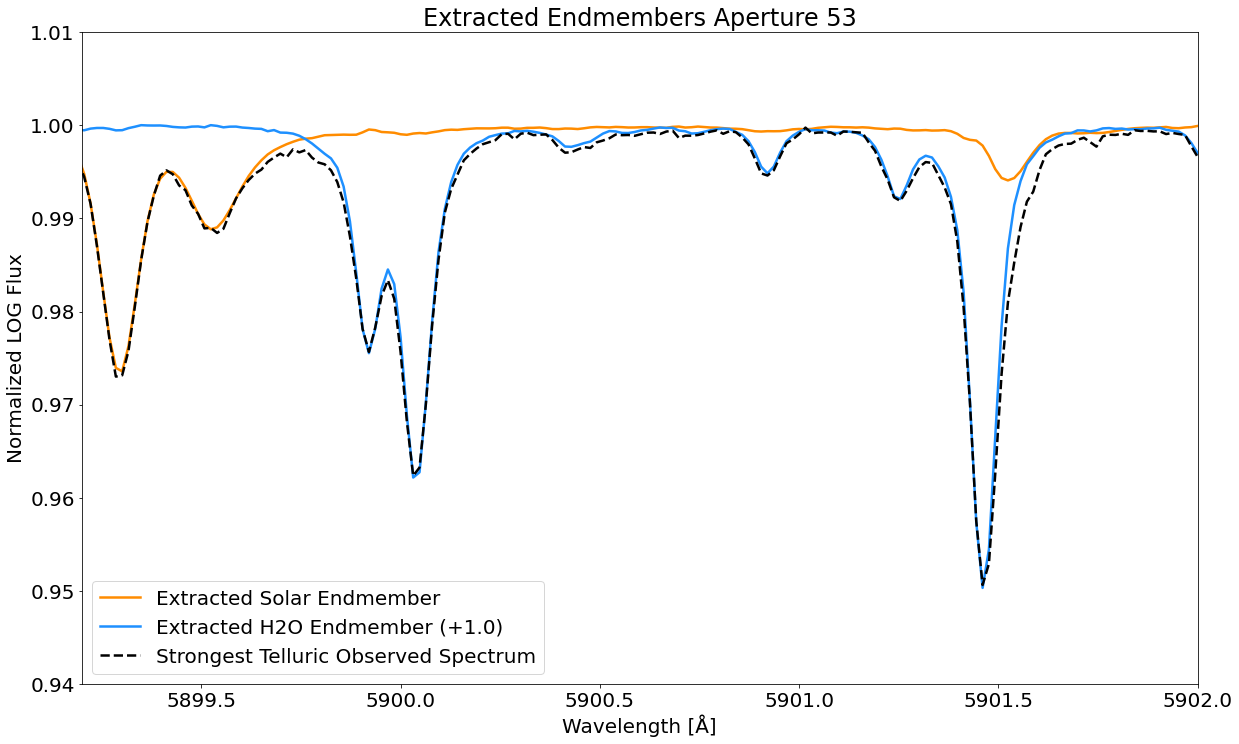

In [6]:
%matplotlib inline
if order==53:
    # Collecting Endmembers
    endmember = weights.detach().numpy()
    S = endmember[:,0] # solar
    T = endmember[:,1] +1.00 # telluric H2O (+1 to bring to same location as solar spectrum)
    obs = train[np.argmin(np.mean(train, axis=1))] # Observed spectra with strongest tellurics in training
   
    # Shifting to extracted solar component to observation with strongest tellurics. 
    # Light speed in km/s
    c = 299792.458
    # Berv of solar component
    v = berv_ref_init_s[np.argmin(np.mean(train, axis=1))]
    # wave axis matching the observation 
    wave_prime = wave * (1.0 + v / c)
    # Interpolate to new axis 
    f = interpolate.interp1d(wave,S,bounds_error=False,fill_value=np.nan,kind='linear') 
    S_obs  = f(wave_prime)
    
    # Plotting
    plt.figure(figsize=(20,12))
    plt.title('Extracted Endmembers Aperture 53',fontsize=24)
    plt.plot(wave,S_obs+0.0,'-',label='Extracted Solar Endmember',color='darkorange',alpha=1,linewidth=2.5)
    plt.plot(wave,T+0.,'-',label='Extracted H2O Endmember (+1.0)',color='dodgerblue',alpha=1,linewidth=2.5) 
    plt.plot(wave,obs,'--',label='Strongest Telluric Observed Spectrum',color='black',alpha=1,linewidth=2.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.xlabel('Wavelength [Å]',fontsize=20)
    plt.ylabel('Normalized LOG Flux',fontsize=20)
    plt.axis([5899.2,5902,0.94,1.01])

### Converting tellurics to transmission spectra

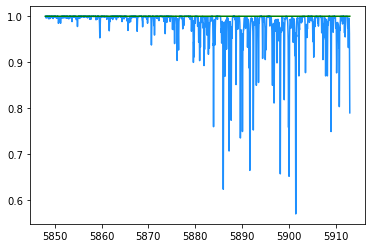

In [7]:
AE_S_log = endmember[:,0] # sun
AE_H2O_log = endmember[:,1] #  H2O
if n_dim==3:
    AE_O2_log = endmember[:,2] #  O2
    AE_O2_log = np.clip(AE_O2_log, -1, 0)
    
AE_H2O_log = np.clip(AE_H2O_log, -1, 0)

AE_H2O = nonLogconv(AE_H2O_log)
AE_O2 = np.ones(P)
if n_dim==3:
    AE_O2 = nonLogconv(AE_O2_log)   
plt.plot(Wave,AE_H2O,color='dodgerblue')
plt.plot(Wave,AE_O2,color='green')